# 1. Setup

In [1]:
import os
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import mlflow
from mlflow import log_metric, log_param
from tqdm.notebook import tqdm

from model import UNet, EAST

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
print(config)

{'data': {'dir': 'Data/Detection-Big', 'height': 320, 'width': 320, 'channels': 3, 'geometry_scale_factor': 64}, 'model': {'name': 'EAST', 'geometry': 'AABB', 'with_classification': False}, 'training': {'info': '', 'batch_size': 32, 'score_weights_auto': True, 'score_weights_woc': [1, 10], 'score_weights_wc': [1, 10, 10, 10, 10], 'lambda_score': 1, 'lambda_geometry': 1, 'lr': 0.001, 'lr_step_size': 5, 'lr_gamma': 0.5, 'weight_decay': 0.001, 'num_epochs': 30}, 'prediction': {'model_path': 'Models/EAST-Detector-e21.pth', 'device': 'cuda', 'batch_size': 4, 'score_threshold': 0.8, 'iou_threshold': 0.1}, 'evaluation': {'predictions_dir_name': 'Annotations-AABB-Pred-EAST-0.8-0.1', 'iou_threshold': 0.75}}


In [3]:
train_dir = os.path.join(config['data']['dir'], 'Train')
val_dir = os.path.join(config['data']['dir'], 'Val')
test_dir = os.path.join(config['data']['dir'], 'Test')
print(train_dir, val_dir, test_dir)

Data/Detection-Big/Train Data/Detection-Big/Val Data/Detection-Big/Test


In [4]:
num_cpus = os.cpu_count()
print(num_cpus)
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

8
cuda


In [5]:
image_height = config['data']['height']
image_width = config['data']['width']

# 2. Define dataset

In [6]:
class DetectionDataset(Dataset):
    
    def __init__(self, data_dir, geometry, with_classification):
        self.data_dir = data_dir
        self.geometry = geometry
        self.with_classification = with_classification
        self.height = config['data']['height']
        self.width = config['data']['width']
        self.geometry_scale_factor = config['data']['geometry_scale_factor']
        self.image_dir = os.path.join(self.data_dir, 'Images')
        self.ann_dir = os.path.join(self.data_dir, f'Annotations-{geometry}')
        self.image_fns = os.listdir(self.image_dir)
        self.lang2id = {'Tamil':1, 'Hindi':2, 'Telugu':3, 'Malayalam':4, 'Punjabi':5, 'English':6}
        self.id2lang = {v:k for k,v in self.lang2id.items()}
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        self.image_fn = image_fn
        image_fp = os.path.join(self.image_dir, image_fn)
        image = cv2.imread(image_fp)
        x = self.image_transform(image)
        
        if self.with_classification:
            lang_id = self.lang2id[image_fn.split('_')[0]]
        else:
            lang_id = 1
            
        ann_fn = f'{self.image_fns[index].split(".")[0]}.csv'
        ann_fp = os.path.join(self.ann_dir, ann_fn)
        ann_df = pd.read_csv(ann_fp)
        y_score, y_geometry = self.ann_transform(ann_df, lang_id)
        
        return x, y_score, y_geometry
    
    def image_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def image_transform_inverse(self, transformed_image):
        transform_ops = transforms.Compose([
            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
        ])
        return transform_ops(transformed_image)
    
    def ann_transform(self, ann_df, class_label, shift_ratio=0.3):
        if self.geometry == 'AABB':
            y_score = np.zeros((self.height, self.width))
            for x, y, w, h in ann_df.values:
                shift = shift_ratio * min(w, h)
                x = int(x + shift)
                y = int(y + shift)
                w = int(w - 2*shift)
                h = int(h - 2*shift)
                y_score = cv2.rectangle(y_score, (x, y), (x+w, y+h), color=class_label, thickness=-1)
            y_score = y_score.astype('int32')
            
            y_geometry = np.zeros((4, self.height, self.width))
            for x, y, w, h in ann_df.values:
                w = min(w, image_width-x-1)
                h = min(h, image_height-y-1)
                y_geometry[0, y:y+h+1, x:x+w+1] = np.array([list(range(w+1))]*(h+1)) # left 
                y_geometry[1, y:y+h+1, x:x+w+1] = np.array([list(range(h+1))]*(w+1)).T # top
                y_geometry[2, y:y+h+1, x:x+w+1] = np.array([list(range(w+1))[::-1]]*(h+1)) # right 
                y_geometry[3, y:y+h+1, x:x+w+1] = np.array([list(range(h+1))[::-1]]*(w+1)).T # bottom
            y_geometry = y_geometry / self.geometry_scale_factor

        else: 
            raise NotImplementedError()
        
        return y_score, y_geometry

In [7]:
geometry = config['model']['geometry']
with_classification = config['model']['with_classification']
trainset = DetectionDataset(train_dir, geometry=geometry, with_classification=with_classification)
print(len(trainset))

55000


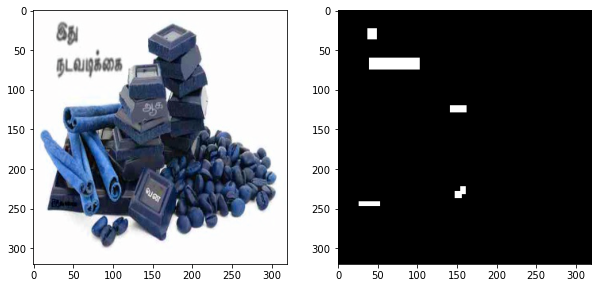

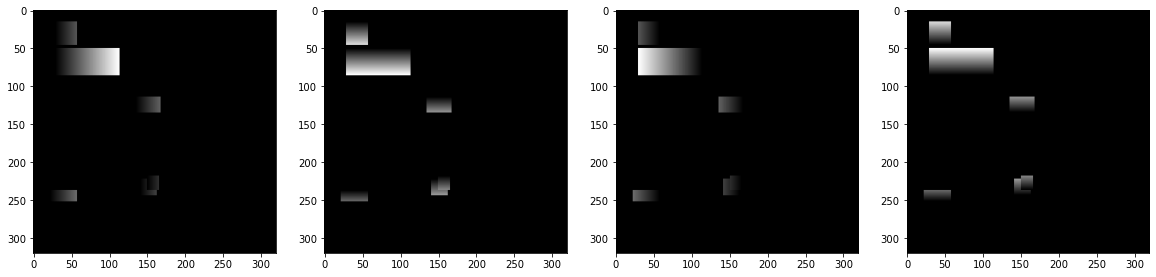

In [9]:
x, y_score, y_geometry = trainset[0]

image = trainset.image_transform_inverse(x)
image = np.transpose(image, (1, 2, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # w, h
axes[0].imshow(image)
axes[1].imshow(y_score, cmap='gray')

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(y_geometry[0], cmap='gray')
axes[1].imshow(y_geometry[1], cmap='gray')
axes[2].imshow(y_geometry[2], cmap='gray')
axes[3].imshow(y_geometry[3], cmap='gray')
plt.show()

# 3. Define loss

In [10]:
def compute_score_loss(Y_score_pred_logits, Y_score, weights):
    """
    Parameters:
    -----------
    Y_score_pred_logits : Tensor of shape(batch_size, num_classes, height, width)
    Y_score : Tensor of shape(batch_size, height, width)
    """
    if weights is None:
        if with_classification:
            beta = ((Y_score == 0).sum().float() / torch.numel(Y_score)).item() # % of background
            weights = [1 - beta] + [beta] * 5
            weights = torch.tensor(weights).float().to(device) 
            weights = weights / weights.sum()
        else:
            weights = (Y_score == 0).sum().float() / (Y_score > 0).sum().float()
        
    if with_classification:
        criterion = nn.CrossEntropyLoss(weight=weights)
        Y_score = Y_score.long()
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
        Y_score_pred_logits = torch.squeeze(Y_score_pred_logits, dim=1)
        Y_score = Y_score.float()
    score_loss = criterion(Y_score_pred_logits, Y_score)
    return score_loss

In [11]:
def compute_geometry_loss(Y_geometry_pred, Y_geometry, Y_score):
    """
    Parameters:
    -----------
    Y_geometry_pred : Tensor of shape(batch_size, 4, height, width)
    Y_geometry : Tensor of shape(batch_size, 4, height, width)
    """
    left_pred = Y_geometry_pred[:, 0, :, :]
    top_pred = Y_geometry_pred[:, 1, :, :]
    right_pred = Y_geometry_pred[:, 2, :, :]
    bottom_pred = Y_geometry_pred[:, 3, :, :]
    
    left = Y_geometry[:, 0, :, :].float()
    top = Y_geometry[:, 1, :, :].float()
    right = Y_geometry[:, 2, :, :].float()
    bottom = Y_geometry[:, 3, :, :].float()
    
    prediction_area = (left_pred + right_pred) * (top_pred + bottom_pred)
    actual_area = (left + right) * (top + bottom)
    intersection_width = torch.min(left_pred, left) + torch.min(right_pred, right)
    intersection_height = torch.min(top_pred, top) + torch.min(bottom_pred, bottom)
    intersection_area = intersection_width * intersection_height
    union_area = prediction_area + actual_area - intersection_area
    
    mask = [Y_score > 0]
    intersection_area = intersection_area[mask]
    union_area = union_area[mask]
    iou = intersection_area / union_area
    iou = torch.clamp(iou, min=0.01)
    geometry_loss = -torch.log(iou)
    geometry_loss = geometry_loss.mean()
    
    return geometry_loss

# 4. Train the model

In [12]:
batch_size = config['training']['batch_size']

lambda_score = config['training']['lambda_score']
lambda_geometry = config['training']['lambda_geometry']
lr = config['training']['lr']
lr_step_size = config['training']['lr_step_size']
lr_gamma = config['training']['lr_gamma']
weight_decay = config['training']['weight_decay']

num_epochs = config['training']['num_epochs']
print_every = num_epochs // 10

In [13]:
trainset = DetectionDataset(train_dir, geometry=geometry, with_classification=with_classification)
valset = DetectionDataset(val_dir, geometry=geometry, with_classification=with_classification)
#testset = DetectionDataset(test_dir, geometry=geometry, with_classification=with_classification)
print(len(trainset), len(valset))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=num_cpus)
#test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_cpus)
print(len(train_loader), len(val_loader))

55000 1200
1719 1200


In [14]:
model_name = config['model']['name']
geometry = config['model']['geometry']
with_classification = config['model']['with_classification']

if model_name == 'UNet':
    model = UNet(image_width=image_width,
                 geometry=geometry, 
                 with_classification=with_classification)
elif model_name == 'EAST':
    model = EAST(image_width=image_width, 
                 geometry=geometry, 
                 with_classification=with_classification)
model = nn.DataParallel(model)
model = model.to(device)

In [15]:
if with_classification:
    score_weights = config['training']['score_weights_wc']
else:
    score_weights = config['training']['score_weights_woc']
score_weights = torch.tensor(score_weights).float()
score_weights = score_weights / score_weights.sum()
score_weights = score_weights.to(device)
if config['training']['score_weights_auto']:
    score_weights = None
print(score_weights)
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_step_size, gamma=lr_gamma)

None


In [16]:
iteration_losses = []
iteration_lrs = []
epoch_losses = []
epoch_losses_val = []
epoch_lrs = []
with mlflow.start_run():
    
    log_param('info', config['training']['info'])
    log_param('model_name', model_name)
    log_param('batch_size', batch_size)
    log_param('lambda_score', lambda_score)
    log_param('lambda_geometry', lambda_geometry)
    log_param('lr', lr)
    log_param('lr_step_size', lr_step_size)
    log_param('lr_gamma', lr_gamma)
    log_param('weight_decay', weight_decay)
    log_param('num_epochs', num_epochs)
    
    for epoch in tqdm(range(1, num_epochs+1)):
        epoch_loss, epoch_score_loss, epoch_geometry_loss = 0, 0, 0
        epoch_loss_val, epoch_score_loss_val, epoch_geometry_loss_val = 0, 0, 0
        epoch_lr = 0

        model.train()
        for X, Y_score, Y_geometry in tqdm(train_loader, desc="Epoch-{}".format(epoch), leave=False):
            if model_name == 'EAST':
                Y_score = Y_score[:, ::4, ::4] # [-1, 4, h/4, w/4]
                Y_geometry = Y_geometry[:, :, ::4, ::4] / 4 # [-1, 4, h/4, w/4]
            
            X = X.to(device)
            Y_score = Y_score.to(device)
            Y_geometry = Y_geometry.to(device)

            optimizer.zero_grad()
            Y_score_pred_logits, Y_geometry_pred, _ = model(X)
            score_loss = compute_score_loss(Y_score_pred_logits, Y_score, score_weights)
            geometry_loss = compute_geometry_loss(Y_geometry_pred, Y_geometry, Y_score)
            loss = lambda_score * score_loss + lambda_geometry * geometry_loss
            log_metric('iteration_score_loss', score_loss.item())
            log_metric('iteration_geometry_loss', geometry_loss.item())
            log_metric('iteration_loss', loss.item())
            loss.backward()
            optimizer.step()

            iteration_losses.append(loss.item())
            iteration_lrs.append(lr_scheduler.get_last_lr()[0])
            epoch_score_loss += score_loss.item()
            epoch_geometry_loss += geometry_loss.item()
            epoch_loss += loss.item()
            epoch_lr += lr_scheduler.get_last_lr()[0]

        model.eval()
        for X, Y_score, Y_geometry in tqdm(val_loader, desc="Val", leave=False):
            if model_name == 'EAST':
                Y_score = Y_score[:, ::4, ::4] # [-1, h/4, w/4]
                Y_geometry = Y_geometry[:, :, ::4, ::4] / 4 # [-1, 4, h/4, w/4]
                
            X = X.to(device)
            Y_score = Y_score.to(device)
            Y_geometry = Y_geometry.to(device)

            Y_score_pred_logits, Y_geometry_pred, _ = model(X)
            score_loss = compute_score_loss(Y_score_pred_logits, Y_score, score_weights)
            geometry_loss = compute_geometry_loss(Y_geometry_pred, Y_geometry, Y_score)
            loss = lambda_score * score_loss + lambda_geometry * geometry_loss

            epoch_score_loss_val += score_loss.item()
            epoch_geometry_loss_val += geometry_loss.item()
            epoch_loss_val += loss.item()

        lr_scheduler.step()
        epoch_score_loss /= len(train_loader)
        epoch_geometry_loss /= len(train_loader)
        epoch_loss /= len(train_loader)
        epoch_score_loss_val /= len(val_loader)
        epoch_geometry_loss_val /= len(val_loader)
        epoch_loss_val /= len(val_loader)
        epoch_lr /= len(train_loader)
        epoch_losses.append(epoch_loss)
        epoch_losses_val.append(epoch_loss_val)
        epoch_lrs.append(epoch_lr)

        log_metric('epoch_score_loss', epoch_score_loss)
        log_metric('epoch_geometry_loss', epoch_geometry_loss)
        log_metric('epoch_loss', epoch_loss)
        log_metric('epoch_score_loss_val', epoch_score_loss_val)
        log_metric('epoch_geometry_loss_val', epoch_geometry_loss_val)
        log_metric('epoch_loss_val', epoch_loss_val)
        if epoch % print_every == 0:    
            message = "Epoch:{}    TrainLoss:{}    ValLoss:{}    LR:{}".format(epoch, 
                                                                               epoch_loss, 
                                                                               epoch_loss_val, 
                                                                               epoch_lr)
            model_path = f'Models/{model_name}-Detector-e{epoch}.pth'
            torch.save(model.module.state_dict(), model_path)
            print(message)

Epoch:3    TrainLoss:0.8686669424150211    ValLoss:0.9841909832631548    LR:0.0009999999999999543


Epoch:6    TrainLoss:0.7071332400312529    ValLoss:0.8062310828641057    LR:0.0004999999999999771


Epoch:9    TrainLoss:0.6619028235119814    ValLoss:0.7442975931614637    LR:0.0004999999999999771


Epoch:12    TrainLoss:0.587569820873955    ValLoss:0.6816642058889071    LR:0.00024999999999998857


Epoch:15    TrainLoss:0.5636690291920119    ValLoss:0.7811373036106427    LR:0.00024999999999998857


Epoch:18    TrainLoss:0.5123297530006988    ValLoss:0.7168117138867577    LR:0.00012499999999999428


Epoch:21    TrainLoss:0.47668092619408836    ValLoss:0.7464421773515642    LR:6.249999999999714e-05


Epoch:24    TrainLoss:0.4648326183384834    ValLoss:0.7782158115319908    LR:6.249999999999714e-05


Epoch:27    TrainLoss:0.44474028032695645    ValLoss:0.752852061248074    LR:3.124999999999857e-05


Epoch:30    TrainLoss:0.4384460506257517    ValLoss:0.7819809325536092    LR:3.124999999999857e-05



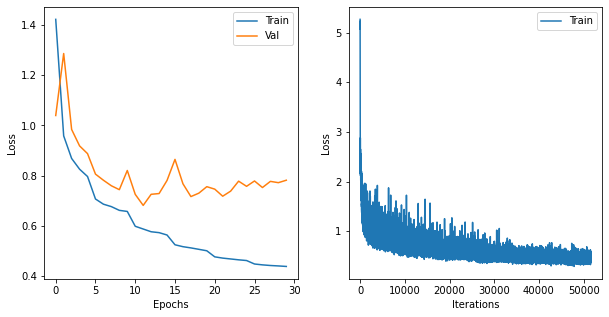

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses, label='Train')
ax1.plot(epoch_losses_val, label='Val')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(iteration_losses, label='Train')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()